# Piecewise Function Approximation

Sometimes we have to optimize for a slightly more complex function than just minimizing or maximizing the sum of a list of variables.
In this case, we can use a piecewise linear or constant function approximation to simplify the problem.

Imagine the following problem:
You are given a list of items, each having a weight between 1 and 1000.
You have to pack these items into k boxes, each with a maximum weight of 1000.
However, in this case we are not trying to maximize the number of packed items or minimize the number of used boxes, but want to have a good distribution of weights due to some constraints (e.g., for ensuring a stable transport).
The optimal weight of a box is 600, and deviations from this value should be minimized.

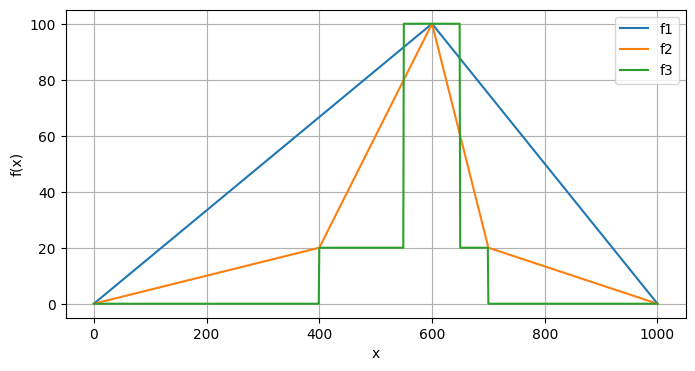

In [110]:
from piecewise_functions import PiecewiseConstantFunction, PiecewiseLinearFunction

f1 = PiecewiseLinearFunction(xs=[0, 600, 1000], ys=[0, 100, 0])
f2 = PiecewiseLinearFunction(xs=[0, 400, 600, 700, 1000], ys=[0, 20, 100, 20, 0])
f3 = PiecewiseConstantFunction(xs=[0, 400, 550, 650, 700, 1001], ys=[0, 20, 100, 20, 0])

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.xlabel("x")
plt.ylabel("f(x)")
x = range(0, 1001)
# plot all functions
for f, label in [(f1, "f1"), (f2, "f2"), (f3, "f3")]:
    plt.plot(x, [f(t) for t in x], label=label)
plt.grid()
plt.legend()
plt.show()

In [111]:
# create instance
import random


def generate_instance(k, num_items):
    items = [random.randint(1, 50) for _ in range(num_items)]
    return items


k = 50
num_items = 500
items = generate_instance(k, num_items)

In [116]:
from piecewise_functions import PiecewiseConstantConstraint, PiecewiseLinearConstraint
from ortools.sat.python import cp_model


def create_model(k: int, items, f):
    model = cp_model.CpModel()
    x = [
        [model.NewBoolVar(f"x[{i}, {b}]") for b in range(k)] for i in range(len(items))
    ]
    for i in range(len(items)):
        model.AddAtMostOne(x[i])
    # simple symmetry breaking
    for b in range(k):
        for b_ in range(b + 1, k):
            model.Add(x[b][b_] == 0)
    # How filled is bin b

    x_fill = [model.NewIntVar(0, 1000, f"x_fill[{i}]") for i in range(k)]
    # basic symmetry breaking
    # for v, v_ in zip(x_fill[:-1], x_fill[1:]):
    #    model.Add(v <= v_)
    for b in range(k):
        model.Add(x_fill[b] == sum(x[i][b] * items[i] for i in range(len(items))))
    if isinstance(f, PiecewiseConstantFunction):
        y = [PiecewiseConstantConstraint(x_fill_, f, model) for x_fill_ in x_fill]
    elif isinstance(f, PiecewiseLinearFunction):
        y = [
            PiecewiseLinearConstraint(model, x_fill_, f, upper_bound=True)
            for x_fill_ in x_fill
        ]
    else:
        raise ValueError("Unknown function type")
    # objective
    model.Maximize(sum(y.y for y in y))
    return model, x_fill

In [117]:
model, x_fill = create_model(k, items, f1)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0xd7a6be6fe7e64a69)
#Variables: 25'200 (#ints: 50 in objective)
  - 25'100 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 500 (#literals: 25'000)
#kExactlyOne: 50 (#literals: 100)
#kLinear1: 1'525 (#enforced: 200)
#kLinear2: 200 (#enforced: 100)
#kLinearN: 50 (#terms: 25'050)

Starting presolve at 0.00s
  6.62e-03s  0.00e+00d  [DetectDominanceRelations] 
  2.81e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  5.90e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=499 #potential_subsets=50 
[Symmetry] Graph for symmetry has 49'753 nodes and 72'028 arcs.
[Symmetry] Symmetry computation done. time: 0.0352417 dtime: 0.0381399
[Symmetry] #generators: 401, average support size: 100
[Symmetry] 2500 orbits with sizes: 18,18,1

In [114]:
model, x_fill = create_model(k, items, f2)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x85c1f975816186b8)
#Variables: 25'250 (#ints: 50 in objective)
  - 25'150 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 500 (#literals: 25'000)
#kExactlyOne: 50 (#literals: 150)
#kLinear1: 1'725 (#enforced: 400)
#kLinear2: 300 (#enforced: 200)
#kLinearN: 50 (#terms: 25'050)

Starting presolve at 0.00s
  6.63e-03s  0.00e+00d  [DetectDominanceRelations] 
  2.84e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  6.75e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=549 #potential_subsets=50 
[Symmetry] Graph for symmetry has 50'403 nodes and 73'128 arcs.
[Symmetry] Symmetry computation done. time: 0.035534 dtime: 0.0383915
[Symmetry] #generators: 401, average support size: 100
[Symmetry] The model contains 100 duplicate

In [115]:
model, x_fill = create_model(k, items, f3)
solver = cp_model.CpSolver()
solver.parameters.max_time_in_seconds = 60
solver.parameters.log_search_progress = True
solver.parameters.relative_gap_limit = 0.01
status = solver.Solve(model)


Starting CP-SAT solver v9.9.3963
Parameters: max_time_in_seconds: 60 log_search_progress: true relative_gap_limit: 0.01
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0xa531c5aace13c9f0)
#Variables: 25'300 (#ints: 50 in objective)
  - 25'200 Booleans in [0,1]
  - 50 in [0,100]
  - 50 in [0,1000]
#kAtMostOne: 500 (#literals: 25'000)
#kLinear1: 1'325
#kLinear2: 150
#kLinearN: 200 (#terms: 25'800)

Starting presolve at 0.00s
  6.58e-03s  0.00e+00d  [DetectDominanceRelations] 
  2.96e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  7.35e-04s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=499 #potential_subsets=100 
[Symmetry] Graph for symmetry has 50'553 nodes and 73'178 arcs.
[Symmetry] Symmetry computation done. time: 0.0343911 dtime: 0.0384068
[Symmetry] #generators: 401, average support size: 100
[Symmetry] 2500 orbits with sizes: 18,18,18,18,18,18,18,18,18,18,...
[Symmetry] Found orbitope of size 50 x 